In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


2023-12-26 15:18:02.277562: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-26 15:18:02.488927: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-26 15:18:02.489003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-26 15:18:02.522984: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-26 15:18:02.592301: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-26 15:18:02.594036: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
data = pd.read_csv('../data/student-por.csv')

In [4]:
Y = data[['G1', 'G2', 'G3']].sum(axis=1)
X = data.drop(['G1', 'G2', 'G3'], axis=1)
X = (X-X.min())/(X.max()-X.min())
Y = Y.apply(lambda x: 1 if x > 36 else 0)

In [5]:
random_state = 9527

pca_1d = PCA(5, random_state=random_state)
L_sk = pca_1d.fit_transform(X)
print(pca_1d.explained_variance_ratio_)
print('L_sk.shape:', L_sk.shape)
print('L_sk:', L_sk[:, :4])


[0.11397245 0.0917797  0.07526358 0.0687543  0.06261955]
L_sk.shape: (649, 5)
L_sk: [[ 0.15695805 -0.55878665 -0.78704099  0.29579253]
 [ 0.06733778 -0.76011544 -0.42695537 -0.11849852]
 [-0.04480769 -0.2574291  -0.91941322  0.45572352]
 ...
 [ 0.77179653 -0.02189488 -0.01720862  0.03977117]
 [ 0.20502902  1.05775931 -0.87245234  0.33873277]
 [ 0.61503528  1.21087866 -0.72392194 -0.1035755 ]]


In [10]:
%%time
log_data = []
best_report= None
curr_best_model = None
best_f1 = 0
for i in range(20, 80):
    X_train, X_test, y_train, y_test = train_test_split(L_sk, Y, test_size=i / 100, random_state=42)
    lr = LogisticRegression()
    model = lr.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]

    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate additional metrics if needed (e.g., precision, recall)

    if f1 > best_f1 and 80 > i > 20 :
        best_f1 = f1
        curr_best_model = model
        best_report = classification_report(y_test, y_pred)
    log_data.append({'Iteration': i, 'F1 Score': f1, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall})



CPU times: user 839 ms, sys: 5.89 ms, total: 845 ms
Wall time: 845 ms


In [7]:
log_df = pd.DataFrame(log_data)
print(best_report)
log_df.to_csv(f"../reports/pca_then_lr.csv", index=False)

              precision    recall  f1-score   support

           0       0.73      0.68      0.70       214
           1       0.60      0.66      0.63       156

    accuracy                           0.67       370
   macro avg       0.67      0.67      0.67       370
weighted avg       0.68      0.67      0.67       370


In [8]:
best_f1

0.6280487804878048

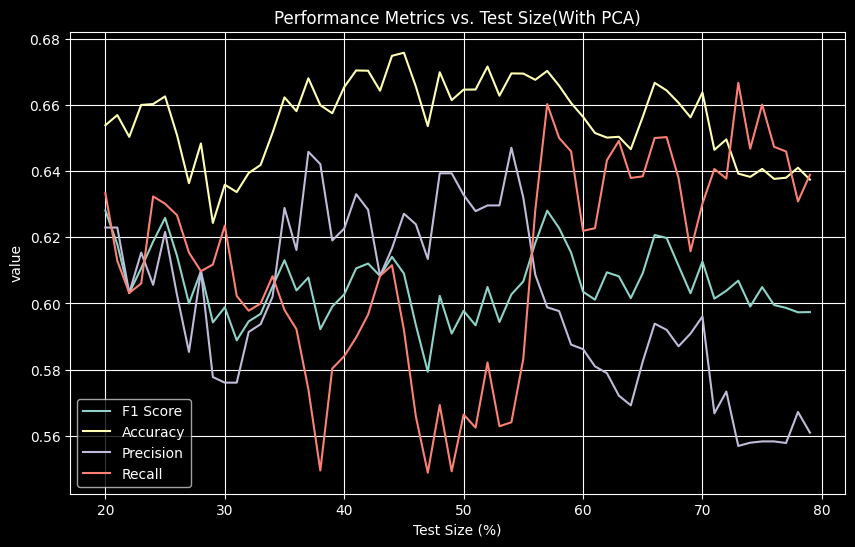

In [9]:
plt.style.use('dark_background')
plt.figure(figsize=(10, 6))
plt.plot(log_df['Iteration'], log_df['F1 Score'], label='F1 Score')
plt.plot(log_df['Iteration'], log_df['Accuracy'], label='Accuracy')
plt.plot(log_df['Iteration'], log_df['Precision'], label='Precision')
plt.plot(log_df['Iteration'], log_df['Recall'], label='Recall')

plt.xlabel('Test Size (%)')
plt.ylabel('value')
plt.title('Performance Metrics vs. Test Size(With PCA)')
plt.legend()
plt.grid(True)
plt.show()